## Training with Pre-trained models
Authors:
- Mario Izquierdo
- Martín Romero

In this notebook we are going to experiment with pre-trained models to solve the proposed image classification problem. Specifically in this notebook we are going to experiment with the VGG16 pretrained network. The way the model will be trained will be using fine-tuning, that consists of unfreezing a few of the top layers of a frozen model base used for feature extraction.

In [1]:
import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#tf.config.set_visible_devices([], 'GPU')

### Load dataset

We load the images from our dataset to create the train, validation and test sets. In this case we have used an image size of (180,180) due to the limited computational capacity of our computer.

In [3]:
img_size = 180
image_size = (img_size, img_size)
img_tensor_shape = (img_size, img_size, 3)
batch_size = 32
train_dataset = image_dataset_from_directory(
    '../data/new_data/train',
    image_size = image_size,
    batch_size = batch_size)
test_dataset = image_dataset_from_directory(
    '../data/new_data/test',
    image_size = image_size,
    batch_size=batch_size)
val_dataset = image_dataset_from_directory(
    '../data/new_data/validation',
    image_size = image_size,
    batch_size=batch_size)

Found 10778 files belonging to 5 classes.
Found 1497 files belonging to 5 classes.
Found 2696 files belonging to 5 classes.


## Using VGG16 model

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

### Unfreezing a few top layers

In [5]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Creating the model
We added to the pretrained model, a final layer with Dropout, to adapt the network to our problem.

In [6]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

#### Fitting the model

In [7]:
### Fine-tuning the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
  
callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     filepath="models/fine_tuning_VGG16.keras",
    #     save_best_only=True,
    #     monitor="val_loss"),   Serialization error
    
    # EarlyStopping to stop training when `val_loss` is not improving
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
]
history = model.fit(
    train_dataset,
    epochs=50, 
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6697 - loss: 6.6091 - val_accuracy: 0.9180 - val_loss: 0.3418
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8954 - loss: 0.5291 - val_accuracy: 0.9444 - val_loss: 0.2386
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9329 - loss: 0.2807 - val_accuracy: 0.9547 - val_loss: 0.1908
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9579 - loss: 0.1608 - val_accuracy: 0.9611 - val_loss: 0.1734
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9780 - loss: 0.0800 - val_accuracy: 0.9655 - val_loss: 0.1699
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9822 - loss: 0.0629 - val_accuracy: 0.9633 - val_loss: 0.1620
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9900 - loss: 0.0326 - val_accuracy: 0.9677 - val_loss: 0.1841
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9920 - loss: 0.0242 - 

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy: ', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9688 - loss: 0.1254
Accuracy:  0.9639278650283813


## Plotting results
We plot the evolution of the accuracy (in training and validation) and the evolution of the loss (in training and validation)

In [9]:
#Function to plot the results
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r-o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

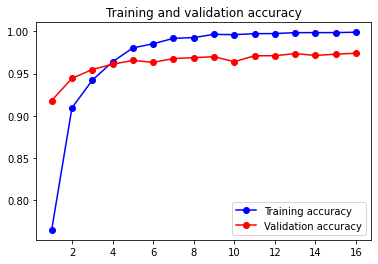

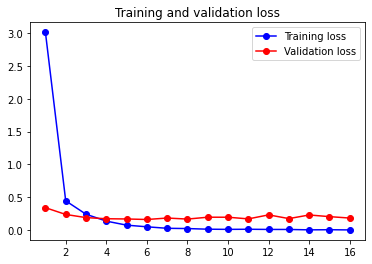

In [10]:
plot(history)

After seeing the results of the network, we see that a good result is obtained, exceeding 90% accuracy. We also see that this percentage is reached after a few training periods and then during all the remaining periods the accuracy remains quite similar.

### Saving the results in a .csv

In [11]:
val_loss, val_acc = model.evaluate(val_dataset)

85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9656 - loss: 0.1749


In [12]:
import os

def save_model_results(file_path, model_name, accuracy):
    """
    This function saves the model's accuracy to a CSV file. It checks if the file exists
    to add a header if necessary and then opens the file in append mode to add
    the model name and accuracy.
    """
    # Check if the file exists to decide on adding the header
    header_needed = not os.path.isfile(file_path)
    # Open the file in append mode, which creates the file if it doesn't exist
    with open(file_path, "a") as file:
        # Add a header if the file was just created
        if header_needed:
            file.write("model_name,accuracy\n")
        # Append the model name and accuracy to the file
        file.write(f"{model_name},{accuracy:.3f}\n")
    

In [13]:
save_model_results('val_results.csv', 'preTrained_FineTuning_VGG16', val_acc)
save_model_results('test_results.csv', 'preTrained_FineTuning_VGG16', test_acc)